In [9]:
import os
import glob
import numpy as np
# For NIfTI files
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import random

In [10]:
DATA_DIR = 'Dataset/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
patient_folders = glob.glob(os.path.join(DATA_DIR, 'BraTS20_Training_*'))
print(f"Size of Training data : {len(patient_folders)}")

Size of Training data : 369


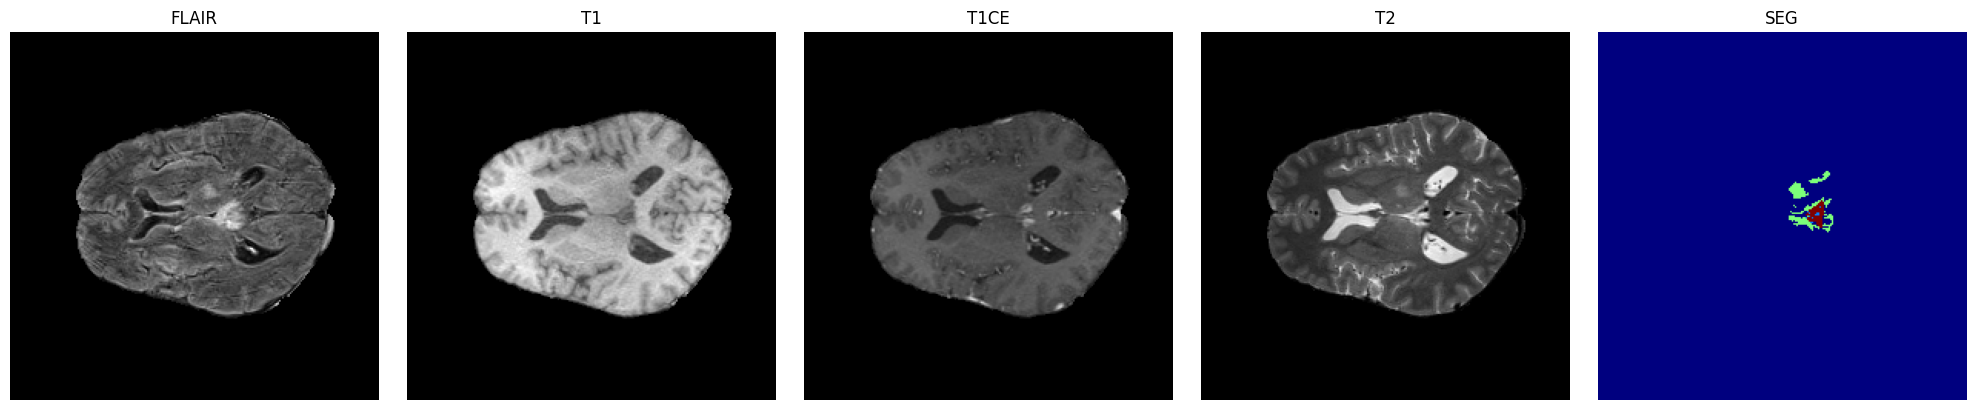

In [11]:
def visualize_sample(patient_path):
    patient_id = os.path.basename(patient_path)
    
    paths = {
        'flair': os.path.join(patient_path, f"{patient_id}_flair.nii"),
        't1': os.path.join(patient_path, f"{patient_id}_t1.nii"),
        't1ce': os.path.join(patient_path, f"{patient_id}_t1ce.nii"),
        't2': os.path.join(patient_path, f"{patient_id}_t2.nii"),
        'seg': os.path.join(patient_path, f"{patient_id}_seg.nii")
    }

    flair = nib.load(paths['flair']).get_fdata()
    slice_idx = flair.shape[2]//2
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))

    for i, (name, path) in enumerate(paths.items()):
        img = nib.load(path).get_fdata()
        if name == 'seg':
            axes[i].imshow(img[:, :, slice_idx], cmap='jet')
        else:
            axes[i].imshow(img[:, :, slice_idx], cmap='gray')
        axes[i].set_title(name.upper())
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()

if len(patient_folders) > 0:
    visualize_sample(patient_folders[0])

In [12]:
# SLIDING WINDOW PROTOCOL

def normalize_volume(volume):
    """
    Normalizes a 3D volume using z-score normalization on non-background voxels.
    """

    mask = volume > 0
    if np.sum(mask) == 0:
        return volume
    
    mean = volume[mask].mean()
    std = volume[mask].std()
    
    # Apply z-score normalization: (x - mean) / std
    volume[mask] = (volume[mask] - mean) / (std + 1e-8)

    return volume


def extract_patches_from_volume(volume, patch_shape, stride_shape):
    """
    Extracts 3D patches from a volume using a sliding window approach.
    
    Parameters:
    - volume: 4D array (H, W, D, C) or 3D array (H, W, D)
    - patch_shape: tuple (pH, pW, pD) defining the size of each patch
    - stride_shape: tuple (sH, sW, sD) defining the step size in each dimension
    
    Returns:
    - patches: NumPy array of all extracted patches
    - coords: List of (y, x, z) coordinates for the top-left corner of each patch
    """
    

    if len(volume.shape) == 3:
        volume = np.expand_dims(volume, axis=-1)
    
    # Height, Width, Depth, Channels
    H, W, D, C = volume.shape
    
    # patch Height, patch Width, patch Depth
    pH, pW, pD = patch_shape
    
    # stride (step size)
    sH, sW, sD = stride_shape
    
    patches = []
    coords = []
    
    # Number of patches that fit in each dimension
    nH = ((H - pH) // sH) + 1  
    nW = ((W - pW) // sW) + 1  
    nD = ((D - pD) // sD) + 1  
    
    for z in range(nD):
        for y in range(nH): 
            for x in range(nW):
                z_start = z * sD  
                y_start = y * sH  
                x_start = x * sW  
                
                patch = volume[y_start:y_start+pH, x_start:x_start+pW, z_start:z_start+pD, :]
                if patch.shape[:3] != patch_shape:
                    continue
                
                patches.append(patch)
                coords.append((y_start, x_start, z_start))

    return np.array(patches), coords


def reconstruct_volume_from_patches(patches, coords, original_shape, patch_shape):
    """
    Reconstructs a full 3D volume from overlapping patches by averaging.

    - patches: Array of patch predictions
    - coords: List of top-left coordinates for each patch
    - original_shape: Tuple (H, W, D, C) of the original volume
    - patch_shape: Tuple (pH, pW, pD) of each patch
    
    Returns:
    - reconstructed: Full-resolution reconstructed volume
    """

    H, W, D, C = original_shape
    pH, pW, pD = patch_shape
    
    reconstructed = np.zeros(original_shape, dtype=np.float32)
    count_map = np.zeros(original_shape[:-1], dtype=np.float32)
    
    for i, (y, x, z) in enumerate(coords):
        patch = patches[i]
        reconstructed[y:y+pH, x:x+pW, z:z+pD, :] += patch
        count_map[y:y+pH, x:x+pW, z:z+pD] += 1
    
    count_map = np.expand_dims(count_map, axis=-1)
    reconstructed /= np.maximum(count_map, 1.0)
    
    return reconstructed

In [13]:
# DATA GENERATOR FOR PATCH-BASED TRAINING

class BrainTumorGenerator(tf.keras.utils.Sequence):
    """
    Custom data generator that inherits from tf.keras.utils.Sequence.
    Generates batches of random 3D patches from brain MRI volumes for training.
    Using Sequence ensures proper multiprocessing support and avoids data duplication.
    """
    
    def __init__(self, patient_folders, batch_size=2, patch_size=(64, 64, 64), stride=(32, 32, 32)):
        """
        Initialize the generator with dataset parameters.
        
        Parameters:
        - patient_folders: List of paths to patient directories
        - batch_size: Number of patches per batch (default: 2)
        - patch_size: 3D dimensions of each extracted patch (default: 64x64x64)
        - stride: Step size for sliding window (unused during training, kept for consistency)
        """

        self.patient_folders = patient_folders
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.stride = stride
        self.indices = np.arange(len(self.patient_folders))
    
    def __len__(self):
        """
        Number of batches per epoch.
        """
        return len(self.patient_folders) // self.batch_size

    def __getitem__(self, index):
        """
        Generates one batch of data when requested by the model during training.
        
        Returns:
        - X: Array of input patches with shape (batch_size, pH, pW, pD, 4)
        - y: Array of segmentation masks with shape (batch_size, pH, pW, pD, 1)
        """

        batch_folders = self.patient_folders[index*self.batch_size:(index+1)*self.batch_size]
        
        X = []
        y = []
        
        for patient_path in batch_folders:
            patient_id = os.path.basename(patient_path)
            vol_path = {
                'flair': os.path.join(patient_path, f"{patient_id}_flair.nii"),  
                't1': os.path.join(patient_path, f"{patient_id}_t1.nii"),        
                't1ce': os.path.join(patient_path, f"{patient_id}_t1ce.nii"),     
                't2': os.path.join(patient_path, f"{patient_id}_t2.nii"),        
                'seg': os.path.join(patient_path, f"{patient_id}_seg.nii")       
            }
            
            modalities = []
            for mod in ['flair', 't1', 't1ce', 't2']:
                img = nib.load(vol_path[mod]).get_fdata().astype(np.float32)
                img = normalize_volume(img)
                modalities.append(img)
            
            volume = np.stack(modalities, axis=-1)
            mask = nib.load(vol_path['seg']).get_fdata().astype(np.float32)
            mask[mask > 0] = 1
            mask = np.expand_dims(mask, axis=-1)
        
            H, W, D, _ = volume.shape
            
            # RANDOM PATCH EXTRACTION WITH TUMOR PREFERENCE
            
            h_start = np.random.randint(0, H - self.patch_size[0])  
            w_start = np.random.randint(0, W - self.patch_size[1])  
            d_start = np.random.randint(0, D - self.patch_size[2])  
            
            patch_img = volume[h_start:h_start+self.patch_size[0], 
                               w_start:w_start+self.patch_size[1], 
                               d_start:d_start+self.patch_size[2], :]
            
            patch_mask = mask[h_start:h_start+self.patch_size[0], 
                              w_start:w_start+self.patch_size[1], 
                              d_start:d_start+self.patch_size[2], :]
            
            for _ in range(10): 

                h_start = np.random.randint(0, H - self.patch_size[0])
                w_start = np.random.randint(0, W - self.patch_size[1])
                d_start = np.random.randint(0, D - self.patch_size[2])
                
                patch_mask = mask[h_start:h_start+self.patch_size[0], 
                                  w_start:w_start+self.patch_size[1], 
                                  d_start:d_start+self.patch_size[2], :]
                
                if np.sum(patch_mask) > 100:
                    patch_img = volume[h_start:h_start+self.patch_size[0], 
                                     w_start:w_start+self.patch_size[1], 
                                     d_start:d_start+self.patch_size[2], :]
                    break
            
            X.append(patch_img)
            y.append(patch_mask)

        # X shape: (batch_size, 64, 64, 64, 4) - input patches with 4 MRI channels
        # y shape: (batch_size, 64, 64, 64, 1) - binary segmentation masks
        return np.array(X), np.array(y)

In [14]:
# 3D U-NET ARCHITECTURE

def get_3d_unet(input_size=(64, 64, 64, 4)):
    
    inputs = layers.Input(input_size)
    
    # ENCODER PATH
    
    # Encoder Block 1
    c1 = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling3D((2, 2, 2))(c1)
    
    # Encoder Block 2
    c2 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling3D((2, 2, 2))(c2)

    # BOTTLENECK

    c3 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(c3)

    # DECODER PATH (Expanding Path)
    
    # Decoder Block 1
    u4 = layers.Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c3)
    # Skip connection
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(u4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(c4)
    
    # Decoder Block 2
    u5 = layers.Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c4)
    # Skip connection with c1
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same')(u5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same')(c5)
    
    # OUTPUT LAYER
    outputs = layers.Conv3D(1, (1, 1, 1), activation='sigmoid')(c5)
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

model = get_3d_unet(input_size=(64, 64, 64, 4))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64,    │          0 │ -                 │
│ (InputLayer)        │ 64, 4)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_11 (Conv3D)  │ (None, 64, 64,    │      1,744 │ input_layer_1[0]… │
│                     │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │         64 │ conv3d_11[0][0]   │
│ (BatchNormalizatio… │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_12 (Conv3D)  │ (None, 64, 64,    │      6,928 │ batch_normalizat… │
│                     │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 32, 32,    │          0 │ conv3d_12[0][0]   │
│ (MaxPooling3D)      │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_13 (Conv3D)  │ (None, 32, 32,    │     13,856 │ max_pooling3d_2[… │
│                     │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv3d_13[0][0]   │
│ (BatchNormalizatio… │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_14 (Conv3D)  │ (None, 32, 32,    │     27,680 │ batch_normalizat… │
│                     │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_3     │ (None, 16, 16,    │          0 │ conv3d_14[0][0]   │
│ (MaxPooling3D)      │ 16, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_15 (Conv3D)  │ (None, 16, 16,    │     55,360 │ max_pooling3d_3[… │
│                     │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv3d_15[0][0]   │
│ (BatchNormalizatio… │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_16 (Conv3D)  │ (None, 16, 16,    │    110,656 │ batch_normalizat… │
│                     │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_transpose_2  │ (None, 32, 32,    │     16,416 │ conv3d_16[0][0]   │
│ (Conv3DTranspose)   │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32, 32,    │          0 │ conv3d_transpose… │
│ (Concatenate)       │ 32, 64)           │            │ conv3d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_17 (Conv3D)  │ (None, 32, 32,    │     55,328 │ concatenate_2[0]… │
│                     │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv3d_17[0][0]   │
│ (BatchNormalizatio… │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_18 (Conv3D)  │ (None, 32, 32,    │     27,680 │ batch_normalizat

 Total params: 341,185 (1.30 MB)

 Trainable params: 340,865 (1.30 MB)

 Non-trainable params: 320 (1.25 KB)

In [16]:
# TRAINING CONFIGURATION AND MODEL TRAINING

# Hyperparameters
BATCH_SIZE = 2
EPOCHS = 5

# PREPARE DATA GENERATOR
train_subset = patient_folders[:10] if len(patient_folders) > 10 else patient_folders
train_gen = BrainTumorGenerator(train_subset, batch_size=BATCH_SIZE)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

history = model.fit(train_gen, epochs=EPOCHS)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.4744 - loss: 0.9001
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.5675 - loss: 0.7960
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.5443 - loss: 0.7972
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.6459 - loss: 0.7215
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.7484 - loss: 0.6059


Running Sliding Window Inference...
Divided volume into 108 patches for inference.
27/27 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step


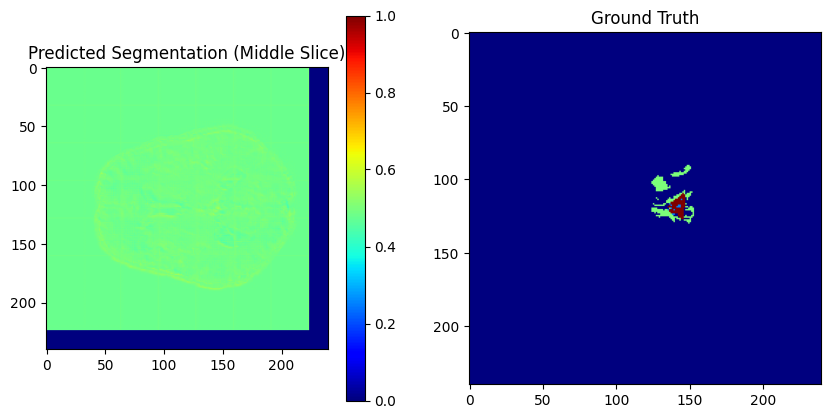

In [17]:
# INFERENCE USING SLIDING WINDOW PROTOCOL

def predict_volume_sliding_window(model, volume, patch_shape=(64, 64, 64), stride=(32, 32, 32)):
    """
    Parameters:
    - model: Trained segmentation model
    - volume: Input 4D volume (H, W, D, C) with C MRI channels
    - patch_shape: Size of patches to extract (default: 64x64x64)
    - stride: Step size for sliding window (default: 32x32x32)
    
    Returns:
    - pred_volume: Full-resolution predicted segmentation map
    """
    
    volume = normalize_volume(volume)
    patches, coords = extract_patches_from_volume(volume, patch_shape, stride)
    print(f"Divided volume into {len(patches)} patches for inference.")
    
    predictions = model.predict(patches, batch_size=4, verbose=1)
    pred_volume = reconstruct_volume_from_patches(
        predictions, 
        coords, 
        (volume.shape[0], volume.shape[1], volume.shape[2], 1),
        patch_shape
    )
    
    return pred_volume

# TEST THE MODEL ON A SAMPLE PATIENT

if len(patient_folders) > 0:
    test_patient = patient_folders[0]
    patient_id = os.path.basename(test_patient)
    
    paths = {
        'flair': os.path.join(test_patient, f"{patient_id}_flair.nii"),
        't1': os.path.join(test_patient, f"{patient_id}_t1.nii"),        
        't1ce': os.path.join(test_patient, f"{patient_id}_t1ce.nii"),    
        't2': os.path.join(test_patient, f"{patient_id}_t2.nii")
    }
    
    mods = []
    
    for m in ['flair', 't1', 't1ce', 't2']:
        img = nib.load(paths[m]).get_fdata().astype(np.float32)
        mods.append(img)
    
    vol_input = np.stack(mods, axis=-1)
    
    print("Running Sliding Window Inference...")
    pred_seg = predict_volume_sliding_window(model, vol_input)
    
    # VISUALIZE RESULTS
    
    slice_idx = pred_seg.shape[2] // 2
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Predicted Segmentation (Middle Slice)")
    plt.imshow(pred_seg[:, :, slice_idx, 0], cmap='jet', vmin=0, vmax=1)
    plt.colorbar()
    
    seg_path = os.path.join(test_patient, f"{patient_id}_seg.nii")
    

    if os.path.exists(seg_path):
        gt = nib.load(seg_path).get_fdata()
        plt.subplot(1, 2, 2)
        plt.title("Ground Truth")
        plt.imshow(gt[:, :, slice_idx], cmap='jet')
    
    plt.show()